RasterioIOError: data/resampled/Ai2_WorldCover_10m_2024_v1_N47W123_Map.tif: No such file or directory

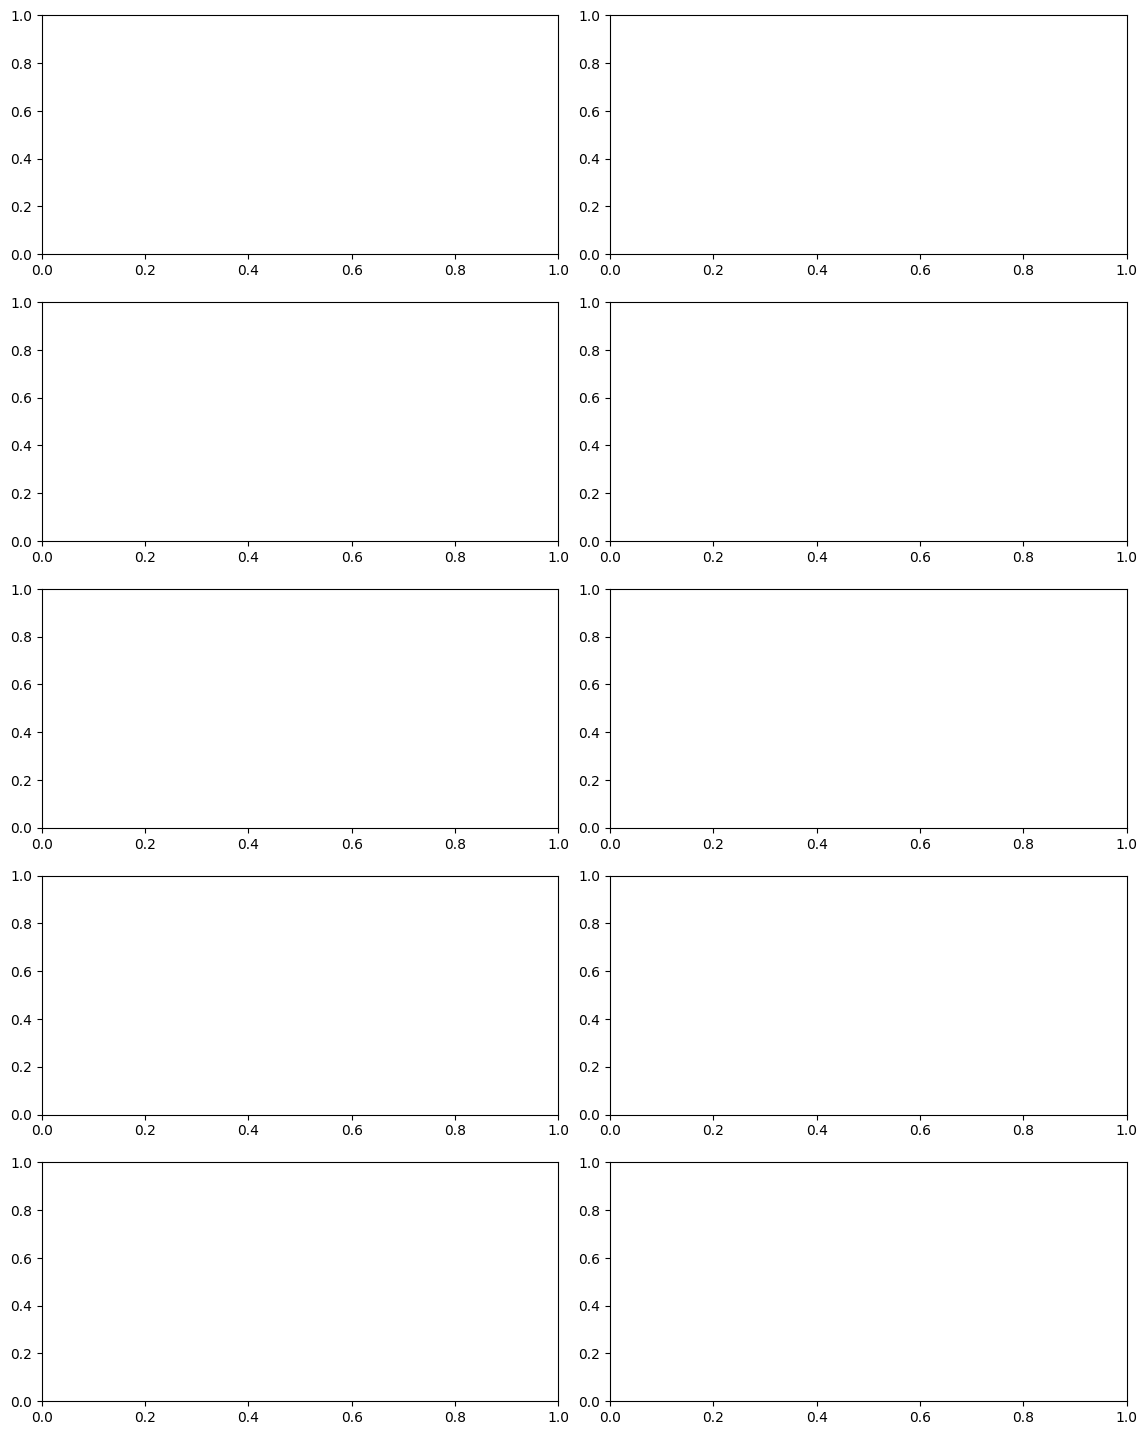

In [ ]:
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap, ListedColormap
from scipy import ndimage
from PIL import Image

def load_and_plot_images_with_zoom_regions(tiff_path1, png_path1, zoom_region1, distance_4km_path1, distance_10m_path1,
                                           tiff_path2, png_path2, zoom_region2, distance_4km_path2, distance_10m_path2):
    """
    Load images with specified zoom regions for two sets: each set includes PNG reference, binary GeoTIFF,
    Sobel edge-detected, and distance to coast heatmaps at 4 km and 10 m resolutions.
    """

    def sobel_edges_scipy(img: np.ndarray) -> np.ndarray:
        """Edge detection using Sobel filter."""
        kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, -2, -1]])
        kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
        img_x = ndimage.convolve(img, kernel_x)
        img_y = ndimage.convolve(img, kernel_y)
        magnitude = np.hypot(img_x, img_y)
        return (magnitude / magnitude.max() * 255).astype(np.uint8)

    # Load PNG and Distance Data
    def load_distance_data(distance_10m_path, distance_4km_path, binary_image, zoom_region, lon_left, lon_right, lat_top, lat_bottom):
        # Load 10 m distance data
        distance_10m = np.load(distance_10m_path)

        # 4 km CSV data
        data_4km = pd.read_csv(distance_4km_path, sep='\t', header=None, names=['longitude', 'latitude', 'distance'])
        data_4km_filtered = data_4km[
            (data_4km['latitude'] >= lat_bottom) & (data_4km['latitude'] <= lat_top) &
            (data_4km['longitude'] >= lon_left) & (data_4km['longitude'] <= lon_right)
        ]
        pivot_table = data_4km_filtered.pivot_table(index='latitude', columns='longitude', values='distance')
        distance_array_4km = pivot_table.values

        # Adjust distance for land points in 10 m data
        distance_10m_adjusted = distance_10m.copy()
        distance_10m_adjusted[binary_image == 0] *= -1
        return distance_array_4km, distance_10m_adjusted[zoom_region]

    # Helper to handle loading and plotting a single dataset
    def process_and_plot_single(axs, col_offset, title_prefix, tiff_path, png_path, zoom_region, distance_4km_path, distance_10m_path):
        # Open the GeoTIFF file for land/sea mask and edge detection
        with rasterio.open(tiff_path) as dataset:
            image = dataset.read(1)
            transform = dataset.transform
            binary_image = np.where(image == 80, 1, 0)
            edge_image = sobel_edges_scipy(binary_image)
            binary_zoom = binary_image[zoom_region]
            edge_zoom = edge_image[zoom_region]

            num_rows, num_cols = binary_zoom.shape
            lon_left, lat_top = rasterio.transform.xy(transform, zoom_region[0].start, zoom_region[1].start)
            lon_right, lat_bottom = rasterio.transform.xy(transform, zoom_region[0].stop - 1, zoom_region[1].stop - 1)
            lats = np.linspace(lat_top, lat_bottom, num=num_rows)
            lons = np.linspace(lon_left, lon_right, num=num_cols)

        # Load 10 m and 4 km distance data and filter it
        distance_array_4km, distance_zoom_10m = load_distance_data(distance_10m_path, distance_4km_path, binary_image, zoom_region, lon_left, lon_right, lat_top, lat_bottom)

        # Load PNG image
        png_image = Image.open(png_path)

        # Custom colormap for distance heatmaps
        colors = ["#008000", "white", "#0000FF"]
        custom_cmap = LinearSegmentedColormap.from_list("green_white_blue", colors, N=256)

        # Titles with prefixes
        titles = [
            f"{title_prefix} High resolution satellite imagery",
            f"{title_prefix} Land-sea mask",
            f"{title_prefix} Sobel edge detection",
            f"{title_prefix} 4 Km distance to coast (NASA)",
            f"{title_prefix} 10 m distance to coast (Ai2)"
        ]

        # Plot each of the 5 subplots for the dataset
        axs[0, col_offset].imshow(png_image)
        axs[0, col_offset].axis('off')
        axs[0, col_offset].set_title(titles[0])

        cmap = ListedColormap(["#FFD700", "#00008B"])
        axs[1, col_offset].imshow(binary_zoom, cmap=cmap, extent=(lons[0], lons[-1], lats[-1], lats[0]))
        axs[1, col_offset].set_aspect('equal')
        axs[1, col_offset].set_title(titles[1])

        axs[2, col_offset].imshow(edge_zoom, cmap='gray', extent=(lons[0], lons[-1], lats[-1], lats[0]))
        axs[2, col_offset].set_aspect('equal')
        axs[2, col_offset].set_title(titles[2])

        norm_4km = TwoSlopeNorm(vmin=distance_array_4km.min(), vcenter=0, vmax=distance_array_4km.max())
        axs[3, col_offset].imshow(distance_array_4km, cmap=custom_cmap, norm=norm_4km)
        axs[3, col_offset].set_aspect('equal')
        axs[3, col_offset].set_title(titles[3])

        vmin_10m, vmax_10m = distance_zoom_10m.min(), distance_zoom_10m.max()
        norm_10m = TwoSlopeNorm(vmin=vmin_10m, vcenter=0, vmax=vmax_10m)
        axs[4, col_offset].imshow(distance_zoom_10m, cmap=custom_cmap, extent=(lons[0], lons[-1], lats[-1], lats[0]), norm=norm_10m)
        axs[4, col_offset].set_aspect('equal')
        axs[4, col_offset].set_title(titles[4])

    # Set up the subplots with reduced spacing
    fig, axs = plt.subplots(5, 2, figsize=(14, 18), constrained_layout=False)
    plt.subplots_adjust(wspace=0.1, hspace=0.2)

    # Process each dataset
    process_and_plot_single(axs, 0, "ESA_WorldCover", tiff_path1, png_path1, zoom_region1, distance_4km_path1, distance_10m_path1)
    process_and_plot_single(axs, 1, "OSM", tiff_path2, png_path2, zoom_region2, distance_4km_path2, distance_10m_path2)

    plt.show()

# Example usage
load_and_plot_images_with_zoom_regions(
    'resampled/Ai2_WorldCover_10m_2024_v1_N47W123_Map.tif', 'seattle_high_res.png', (slice(3000, 5000), slice(7000, 9000)), 'distance_2_coast.csv', '/home/patrickb/litus/Ai2_WorldCover_10m_2024_v1_N47W123_Map_coastal_points_distances.npy',
    'resampled/Ai2_WorldCover_10m_2024_v1_N07E151_Map.tif', 'maldives_high_res_sat.png', (slice(3000, 12000), slice(3500, 12500)), 'distance_2_coast.csv', '/home/patrickb/litus/Ai2_WorldCover_10m_2024_v1_N07E151_Map_coastal_points_distances.npy'
)


In [ ]:
import numpy as np
import pandas as pd
import rasterio
from sklearn.neighbors import BallTree
from tqdm import tqdm
from typing import Tuple
from osgeo import gdal
from multiprocessing import Pool

# Load the coastal data with explicit conversion to numeric
coastal_data = pd.read_csv(
    'src/coastal_data_points/Ai2_WorldCover_10m_2024_v1_N07E151_Map_coastal_points.csv',
    header=None, names=['longitude', 'latitude']
)

# Path to the GeoTIFF
geotiff_path = 'data/resampled/Ai2_WorldCover_10m_2024_v1_N07E151_Map.tif'

# Ensure numeric coastal data
coastal_data['longitude'] = pd.to_numeric(coastal_data['longitude'], errors='coerce')
coastal_data['latitude'] = pd.to_numeric(coastal_data['latitude'], errors='coerce')
coastal_data.dropna(inplace=True)

# Convert coastal data to radians and create the BallTree
coastal_data_rad = np.radians(coastal_data[['latitude', 'longitude']].values)
tree = BallTree(coastal_data_rad, metric='haversine')

# Load the GeoTIFF and generate a grid of all latitude and longitude points
lon_array, lat_array = get_geo_arrays(geotiff_path)
lat_lon_rad = np.radians(np.column_stack((lat_array.ravel(), lon_array.ravel())))

# Define Haversine function to convert radians to meters
EARTH_RADIUS = 6371000
def haversine_dist(radian_coords, nearest_coords):
    """Compute Haversine distance between two points in radians."""
    if radian_coords.ndim == 1:
        radian_coords = radian_coords.reshape(1, -1)
    if nearest_coords.ndim == 1:
        nearest_coords = nearest_coords.reshape(1, -1)

    lat1, lon1 = radian_coords[:, 0], radian_coords[:, 1]
    lat2, lon2 = nearest_coords[:, 0], nearest_coords[:, 1]
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return EARTH_RADIUS * c

# Function to process each batch of points
def process_batch(batch):
    dist, ind = tree.query(batch, k=1)
    nearest_coords = coastal_data_rad[ind.flatten()]
    return haversine_dist(batch, nearest_coords)

# Process the entire set of points in parallel
with Pool(processes=150) as pool:
    # Split data into manageable batches
    results = [pool.apply_async(process_batch, (batch,)) for batch in np.array_split(lat_lon_rad, 150)]

    # Retrieve and concatenate results with progress tracking
    distances = np.concatenate([r.get() for r in tqdm(results, desc="Collecting results")])

# Reshape distances to match the original raster shape and save
output_data = distances.reshape(lat_array.shape)
np.save("Ai2_WorldCover_10m_2024_v1_N07E151_Map_coastal_points_distances.npy", output_data)


In [8]:
pwd

'/home/patrickb/litus'

In [ ]:
from sklearn.neighbors import BallTree
import joblib
import numpy as np
# Assuming coastal_data_rad is already created as an array of coordinates in radians
tree = BallTree(coastal_data_rad, metric='haverzsine')

# Save the BallTree
joblib.dump(tree, 'coastal_data_balltree.joblib')


# To load the BallTree quickly
tree = joblib.load('coastal_data_balltree.joblib')

NameError: name 'coastal_data_rad' is not defined

In [ ]:
def load_tree():
    tree = joblib.load('coastal_data_balltree.joblib')
    tree.query([[0,1]], k=1)


In [29]:
%timeit load_tree()

633 μs ± 2.46 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
